<h1 style="text-align: center;">Прогнозирование заказов такси</h1>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Описание данных

Признак        | Значение
---------------|-------------------
datetime       | время
**num_orders** | количество заказов

# Импорт необходимых библиотек

In [1]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -q lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    OrdinalEncoder, 
    MinMaxScaler, 
    LabelEncoder
)
from sklearn.metrics import root_mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# импортируем модель
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.inspection import permutation_importance

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier

from statsmodels.tsa.seasonal import seasonal_decompose

## Константы

In [6]:
# задаём размер тестовой выборки и random_state
RANDOM_STATE = 42

# train - 90%
# test - 10%
TEST_SIZE = 0.10

# Загрузка данных

In [7]:
try:
    df = pd.read_csv('./datasets/taxi.csv', parse_dates=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

In [8]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Посмотрим на максимальное значение num_orders.

In [10]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Переведём тип данных в int32 для экономии памяти.

In [11]:
df['num_orders'] = df['num_orders'].astype('int32')

Проверим наличие явных дублкатов.

In [12]:
df.duplicated().sum()

0

Дубликаты не обнаружены, пропусков в данных также не наблюдается. Заменим индекс на значение столбца datetime.

In [13]:
df = df.set_index('datetime')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


На данный момент данные представлены за каждые 10 минут. Выполним ресемплирование - будем отображать заказы за каждый час. Для этого суммируем количество заказов за каждый час.

In [14]:
df = df.resample('1h').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Исследовательский анализ данных

In [15]:
sns.set_theme(style="darkgrid")

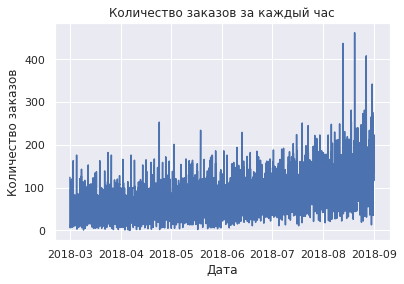

In [16]:
sns.lineplot(x='datetime', 
             y='num_orders',
             data=df.reset_index())

plt.title('Количество заказов за каждый час')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show();

In [17]:
df.sort_index()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


По графику наблюдаем постепенное увеличение количества заказов. По отсортированному индексу узнаём, что данные взяты с 1 марта 2018 года по 31 августа 2018 года, в общем с марта по август 2018 года - за пол года.

Также отметим, что наш временной ряд не является стационарным, потому что его среднее значение и стандартое отклонение меняются со временем, однако он близок к стационарному, поскольку изменения не сильные.

Разложим временной ряд на тренд и сезонную компоненту. Посмотрим на график тренда.

In [18]:
decomposed = seasonal_decompose(df) 

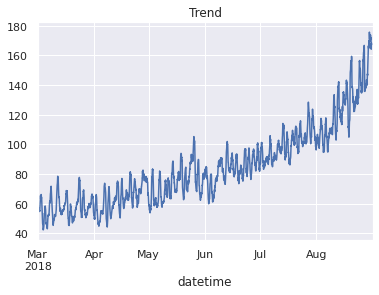

In [19]:
decomposed.trend.plot()
plt.title('Trend')
plt.show();

Отлично видно, что с наступлением весны и до конца лета наблюдается тренд на рост заказов.

Посмотрим график сезонной составляющей за первые 15 дней весны.

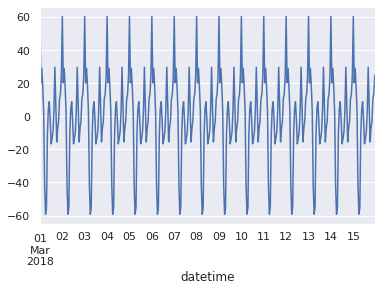

In [20]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot();

Сезонность связана с периодом около суток, продолжим её изучение, посмотрим на график сезонной составляющей за первые двое суток.

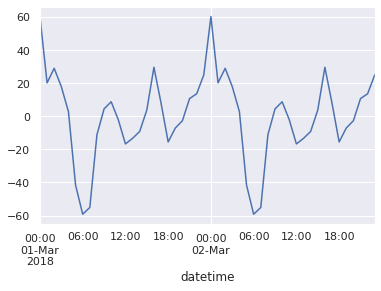

In [21]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot();

В течении суток:
- самое большое количество заказов наблюдается в 00:00
- самое маленькое количество заказов около 6 утра
- в период с 00:00 до 6 утра количество заказов постепенно снижается до минимума
- с 6 утра до 00:00 заказы постепенно растут
- с 6 до 00:00 имеются два пика спроса: около 10:00 и в 15:00
- с 6 до 00:00 самое низкое количество заказов в 12:00 и 18:00

# Добавление новых признаков

Создадим признаки для горизонта прогнозирования в один шаг (1 час). Напишем функцию для создания признаков. 

In [22]:
def make_features(df, target_name, max_lag, rolling_mean_size):
    '''
        Функция создаёт для датасета календарные признаки,
        признаки отстающих значений и скользящее среднее,
        возвращает обновленный датафрейм.
    '''
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target_name].shift(lag)

    data['rolling_mean'] = data[target_name].shift().rolling(rolling_mean_size).mean()
    
    return data

Добавим новые признаки, пока что зададим произвольные значения аргументов.

In [23]:
df = make_features(df, 'num_orders', 5, 4)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,86.5


Функция работает корректно, новые признаки созданы.

Так как мы собираемся обучать модель линейной регрессии, посмотрим на корреляцию признаков.

In [24]:
df.columns

Index(['num_orders', 'month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'rolling_mean'],
      dtype='object')

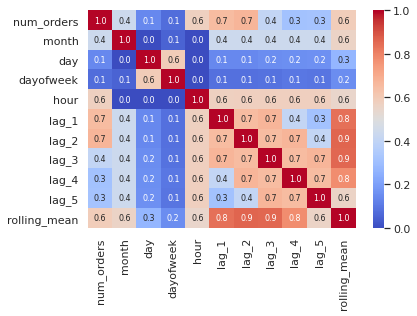

In [25]:
phik_corr = df.phik_matrix(
    interval_cols=['num_orders', 'lag_1', 
                   'lag_2', 'lag_3', 'lag_4', 'lag_5',
                   'lag_6', 'lag_7', 'lag_8', 'lag_9',
                   'lag_10', 'lag_11', 'lag_12', 'lag_13'
                   'lag_14', 'lag_15', 'lag_16', 'lag_17',
                   'lag_18', 'lag_19', 'lag_20', 'lag_21',
                   'lag_22', 'lag_23', 'lag_24',
                  'rolling_mean']
)

sns.heatmap(phik_corr,
            xticklabels=phik_corr.columns.values,
            yticklabels=phik_corr.columns.values,
            cmap='coolwarm',
            annot_kws={"fontsize":8},
            fmt=".1f",
            annot=True);

Целевой признак num_orders сильнее всего зависит от lag_1, lag_2, hour и rolling_mean. То есть на целевой признак сильнее всего влияют два остающих значения, час заказа и скользяще среднее. Мультиколлинеарности не наблюдается.

# Подготовка выборок для обучения моделей

Разделим данные на обучающую и тестовую выборки. Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.

Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет, поэтому их значения - NaN. Удалим их.

In [26]:
train, test = train_test_split(df, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

print(train.shape)
print(test.shape)

(3969, 11)
(442, 11)


В выборках выделим признаки и целевой признак.

In [27]:
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']

X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

Обозначим типы признаков, добавим масштабирование и создадим пайплайн с предподготовкой данных. Создаём итоговый пайплайн для обучения модели.

In [28]:
num_columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4',
               'lag_5', 'rolling_mean']

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression(n_jobs=-1))
    ]
)

Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV. В словаре укажем, какие варианты масштабирования собираемся перебрать. Их три: варианты с разными методами и один вариант без масштабирования.

В словарь гиперпараметров param_grid добавим модели, которые хотим использовать, две линейные и два градиентных бустинга.

Перебираем гиперпараметры моделей. В каждом словаре указываем название модели, её гиперпараметры, метод масштабирования.

In [29]:
param_distributions = [
    {
        'models': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': range(0,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': range(10,100, 10),
        'models__min_samples_split': np.arange(0,1,0.2),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(10, 100, 10),
        'models__max_depth': range(1,10),
        'models__num_leaves': range(1,50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

# Обучение моделей

## Обучение random search

In [30]:
# задаём стратегию разделения данных при кросс-валидации
tscv = TimeSeriesSplit()

# задаём случайный поиск
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=tscv
)

In [31]:
%%time
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

CPU times: user 2min 37s, sys: 2.34 s, total: 2min 40s
Wall time: 2min 41s


/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'rolling_mean'])])),
                                             ('models',
                                              LinearRegression(n_jobs=-1))]),
                   n_jobs=-1,
                   param_distributions=[{'mo...
                                         'models__n_estimators': range(10, 100, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LGBMRegressor(random_state=42)],
                                         'models__max_depth': range(1, 10),
                                         'models__n_estimators': range(10, 100, 10),
                                         'models__num_leaves': range(1, 50),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

## Лучшая модель и её предсказания

In [32]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5',
                                                   'rolling_mean'])])),
                ('models',
                 LGBMRegressor(max_depth=9, n_estimators=90, num_leaves=18,
                               random_state=42))])
Метрика лучшей модели на тренировочной выборке: -25.365003003893698


In [33]:
best_model = randomized_search.best_estimator_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

Качество на тренировочной выборке удовлетворяет условию RMSE < 48.  Выполним предсказания на лучшей модели и посмотрим на качество на тестовой выборке.

In [34]:
preds = best_model.predict(X_test)

score = root_mean_squared_error(y_test, preds)
print(f'Метрика RMSE на тестовой выборке: {score}') 

Метрика RMSE на тестовой выборке: 44.76306847583907


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Качество лучшей модели на тестовой выборке также удовлетворяет условию RMSE < 48. Посмотрим на важность признаков.

In [35]:
results = y_test.reset_index()
results['preds'] = preds
results = results.set_index('datetime')
results.head()

,num_orders,preds
datetime,,
2018-08-13 14:00:00,102,99.327233
2018-08-13 15:00:00,175,115.591684
2018-08-13 16:00:00,144,146.301678
2018-08-13 17:00:00,152,138.151004
2018-08-13 18:00:00,104,98.196664


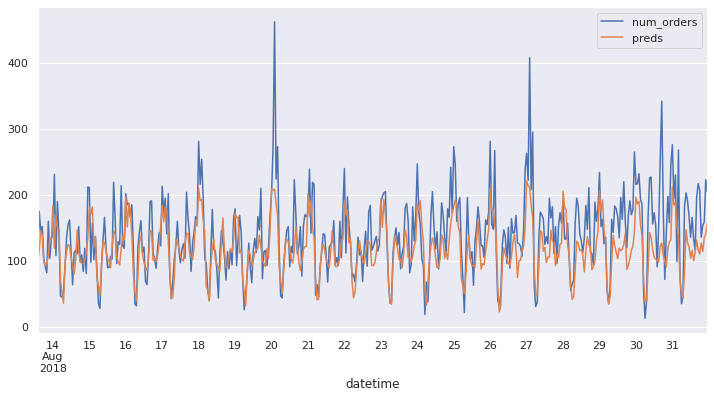

In [36]:
results.plot(figsize=(12, 6));

Наблюдаем, что предсказанные значения очень близки к реальным в большинстве случаев, однако заметны и непредсказанные пики. Тем не менее модель справляется достаточно хорошо.

## Важность признаков для лучшей модели

In [37]:
model_preprocessor = best_model.named_steps['preprocessor']

# сформируем таблицу важности признаков
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': best_model.steps[1][1].feature_importances_
    })

# сортируем таблицу по важности — от большей к меньшей
print(feature_importances.sort_values('Importance', ascending=False))

                Feature  Importance
9       remainder__hour         464
0            num__lag_1         175
6      remainder__month         123
4            num__lag_5         121
5     num__rolling_mean         118
2            num__lag_3         117
1            num__lag_2         113
8  remainder__dayofweek         113
3            num__lag_4         111
7        remainder__day          71


Самым важным признаком является час заказа, что логично. Далее идёт отстающее значение на 1 шаг. Самым не значимым признаком является день месяца, что логично, ведь мы наблюдали сезонность по дням.

Проанализируем SHAP значения. Построим график общей значимости признаков.

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

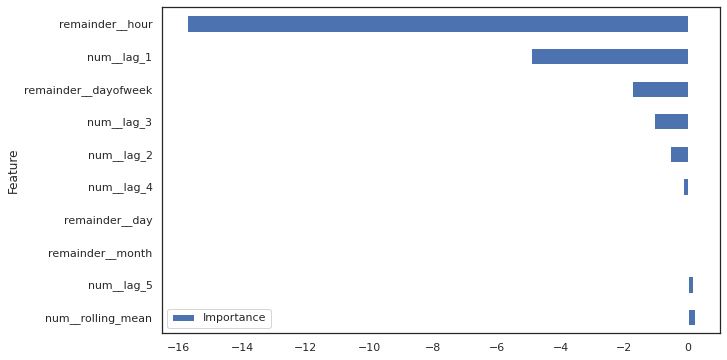

In [38]:
def custom_score(model, X, y):
    y_pred = model.predict(X)
    score = root_mean_squared_error(y, y_pred)
    return score

X_test_scalled = data_preprocessor.fit_transform(X_test)

result = permutation_importance(best_model.steps[1][1], X_test_scalled, y_test, scoring=custom_score)

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

Наблюдаем самый важный признак - час заказа. Второй по важности - отстающее значение на 1 шаг (1 час). Далее важность остальных признаков сильно снижается. Отрицательные значения важности означают, что при случайной перестановке значений в этом признаке, модель работает лучше.

# Результаты

<u>Целью исследования являлось:</u> построить модель для предсказания количества заказов такси на следующий час

Лучшая модель: **LGBMRegressor**

Параметры модели: **max_depth=9, n_estimators=90, num_leaves=18**

Качество на тестовой выборке: **RMSE = 44.76**

<u>Самые важные признаки для модели:</u>
- час заказа
- количество заказов за предыдущий час

<u>Для обучения модели были добавлены следующие новые признаки:</u>
- месяц
- день
- день недели
- час
- 5 отстающих значений
- скользящее среднее с шагом 4 (среднее за 4 часа)

<u>Дополнительные наблюдения:</u>
- с наступлением весны и до конца лета наблюдается тренд на рост заказов

<u>В течении суток:</u>
- самое большое количество заказов наблюдается в 00:00
- самое маленькое количество заказов около 6 утра
- в период с 00:00 до 6 утра количество заказов постепенно снижается до минимума
- с 6 утра до 00:00 заказы постепенно растут
- с 6 до 00:00 имеются два пика спроса: около 10:00 и в 15:00
- с 6 до 00:00 самое низкое количество заказов в 12:00 и 18:00